# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sun May  4 09:47:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu124


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Set up path to the datafolder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

# If image folder doesn't exist, download it
if image_path.is_dir():
  print(f"{image_path} already exists.")
else:
  print(f"Couldn't find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the data
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

    # Unizip the datafile
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
      print(f"Unziping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

Couldn't find data/pizza_steak_sushi directory, creating one...
Unziping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

Random image path: data/pizza_steak_sushi/train/steak/2629750.jpg
Image class: steak
Image height: 512
Image width: 512


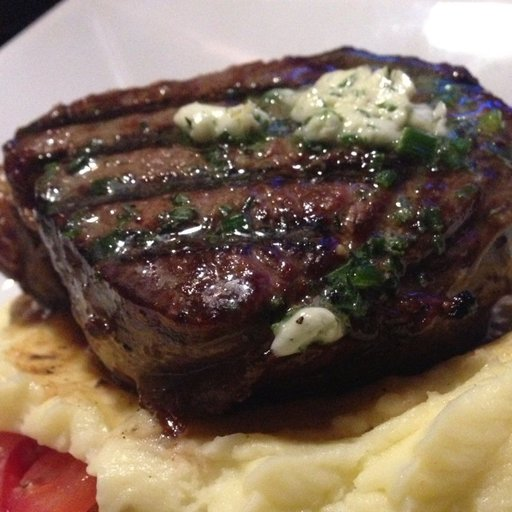

In [6]:
# Visualize an image
import random
from PIL import Image

# Get image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

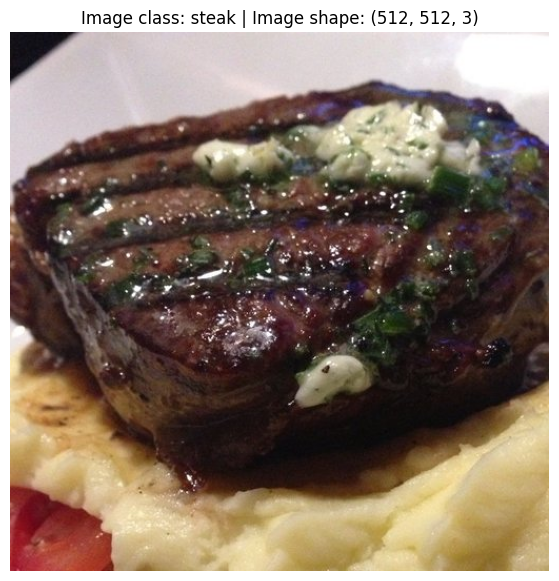

In [7]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
# Write transform for turning images into tensors
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [10]:
# Write a function to plot transformed images
def plot_tranformed_images(image_paths, transform, n=3):
  """
  Plots a series of random images from image_paths.

  It will open n images from image_paths, transform them with tranform
  and plot them side by side.

  Args:
    image_paths (list): a list of the target image paths
    transform (PyTorch transforms): the transform be want to apply to the images.
    n(int, optional): number of images to plot. By default = 3
  """

  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 14)


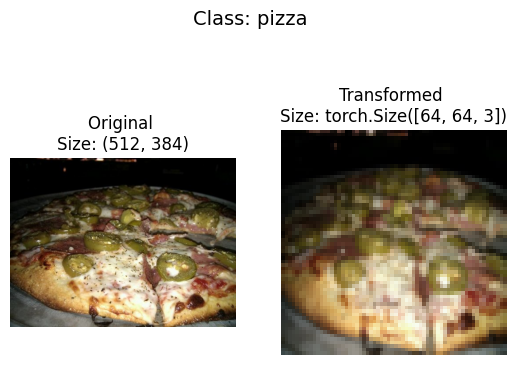

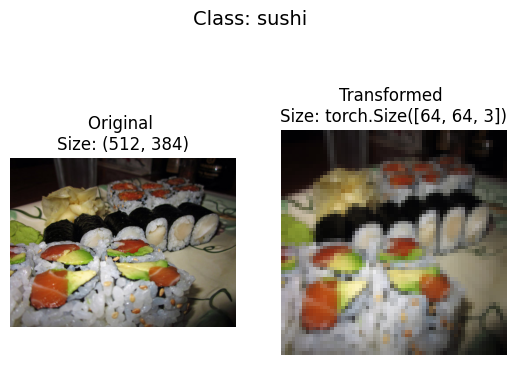

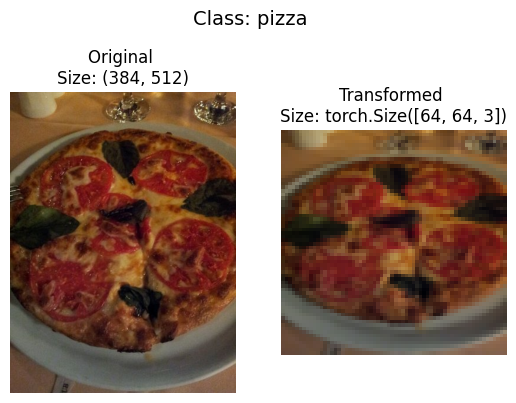

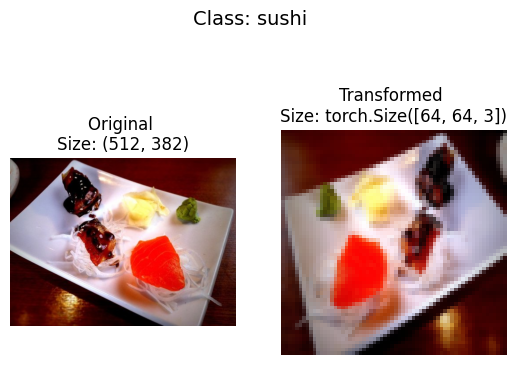

In [11]:
plot_tranformed_images(image_path_list,
                       transform = transform,
                       n = 4)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = transform,
                                  target_transform = None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b54337f98d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b543388cd10>)

In [17]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
class TinnyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features = output_shape)
    )

  def forward(self, x):
    #print(f"[Input] Shape: {x.shape}")
    x = self.conv_block_1(x)
    #print(f"[After conv_block_1] Shape: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"[After classifier] Shape: {x.shape}")
    x = self.classifier(x)

    return x

In [20]:
model_0 = TinnyVGG(input_shape=3,
                   hidden_units = 10,
                   output_shape = len(class_names)).to(device)
model_0

TinnyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [21]:
dummy_input = torch.randn(1, 3, 64, 64).to(device)
model_0(dummy_input)  # <-- this triggers the forward() method


tensor([[-0.0665, -0.1026,  0.0786]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [22]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y). sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [23]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [24]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [25]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 5

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 for 5 epochs
model_0_results_5_epochs = train(model = model_0,
                                 train_dataloader= train_dataloader,
                                 test_dataloader= test_dataloader,
                                 optimizer= optimizer,
                                 loss_fn= loss_fn,
                                 epochs = NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds ")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1091 | train_acc: 0.3086 | test_loss: 1.1156 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0805 | train_acc: 0.4258 | test_loss: 1.1683 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1247 | train_acc: 0.3047 | test_loss: 1.1505 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0881 | train_acc: 0.4258 | test_loss: 1.1265 | test_acc: 0.2604
Total training time: 5.581 seconds 


In [26]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 for 20 epochs
model_0_results_20_epochs = train(model = model_0,
                                 train_dataloader= train_dataloader,
                                 test_dataloader= test_dataloader,
                                 optimizer= optimizer,
                                 loss_fn= loss_fn,
                                 epochs = NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds ")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.4258 | test_loss: 1.1027 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1067 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0817 | train_acc: 0.4258 | test_loss: 1.1247 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1039 | train_acc: 0.3047 | test_loss: 1.1299 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0760 | train_acc: 0.4023 | test_loss: 1.1289 | test_acc: 0.2917
Epoch: 6 | train_loss: 1.0633 | train_acc: 0.4336 | test_loss: 1.1133 | test_acc: 0.3333
Epoch: 7 | train_loss: 0.9488 | train_acc: 0.6016 | test_loss: 1.1100 | test_acc: 0.2917
Epoch: 8 | train_loss: 0.9455 | train_acc: 0.5859 | test_loss: 1.0628 | test_acc: 0.3930
Epoch: 9 | train_loss: 0.9569 | train_acc: 0.4805 | test_loss: 1.0401 | test_acc: 0.4337
Epoch: 10 | train_loss: 0.8952 | train_acc: 0.6289 | test_loss: 0.9638 | test_acc: 0.4830
Epoch: 11 | train_loss: 0.8627 | train_acc: 0.6211 | test_loss: 1.0225 | test_acc: 0.4744
Epoch: 12 | train_l

In [27]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 50

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 for 50 epochs
model_0_results_50_epochs = train(model = model_0,
                                 train_dataloader= train_dataloader,
                                 test_dataloader= test_dataloader,
                                 optimizer= optimizer,
                                 loss_fn= loss_fn,
                                 epochs = NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds ")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7550 | train_acc: 0.5898 | test_loss: 1.0621 | test_acc: 0.3636
Epoch: 2 | train_loss: 0.7832 | train_acc: 0.5469 | test_loss: 1.0236 | test_acc: 0.3532
Epoch: 3 | train_loss: 0.6722 | train_acc: 0.7031 | test_loss: 0.9629 | test_acc: 0.3741
Epoch: 4 | train_loss: 0.7205 | train_acc: 0.7227 | test_loss: 0.9312 | test_acc: 0.4754
Epoch: 5 | train_loss: 0.6501 | train_acc: 0.7617 | test_loss: 0.9935 | test_acc: 0.4953
Epoch: 6 | train_loss: 0.8851 | train_acc: 0.5742 | test_loss: 0.9315 | test_acc: 0.5057
Epoch: 7 | train_loss: 0.6309 | train_acc: 0.7461 | test_loss: 0.9259 | test_acc: 0.6061
Epoch: 8 | train_loss: 0.6521 | train_acc: 0.7695 | test_loss: 1.0466 | test_acc: 0.4148
Epoch: 9 | train_loss: 0.8863 | train_acc: 0.5664 | test_loss: 1.0293 | test_acc: 0.4451
Epoch: 10 | train_loss: 0.6355 | train_acc: 0.7227 | test_loss: 0.9172 | test_acc: 0.5852
Epoch: 11 | train_loss: 0.6645 | train_acc: 0.7227 | test_loss: 0.9764 | test_acc: 0.4451
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [28]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinnyVGG(input_shape=3,
                   hidden_units=20,
                   output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

NUM_EPOCHS = 20

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 for 5 epochs
model_1_results_20_epochs = train(model = model_1,
                                 train_dataloader= train_dataloader,
                                 test_dataloader= test_dataloader,
                                 optimizer= optimizer,
                                 loss_fn= loss_fn,
                                 epochs = NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds ")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1048 | train_acc: 0.4219 | test_loss: 1.1072 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1218 | train_acc: 0.3047 | test_loss: 1.0978 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0916 | train_acc: 0.3906 | test_loss: 1.1000 | test_acc: 0.2188
Epoch: 4 | train_loss: 1.0931 | train_acc: 0.4414 | test_loss: 1.0800 | test_acc: 0.4943
Epoch: 5 | train_loss: 1.0880 | train_acc: 0.4062 | test_loss: 1.0701 | test_acc: 0.3021
Epoch: 6 | train_loss: 1.0469 | train_acc: 0.4453 | test_loss: 1.0843 | test_acc: 0.3636
Epoch: 7 | train_loss: 0.9650 | train_acc: 0.5859 | test_loss: 1.0704 | test_acc: 0.3324
Epoch: 8 | train_loss: 0.8811 | train_acc: 0.5977 | test_loss: 0.9735 | test_acc: 0.4545
Epoch: 9 | train_loss: 0.9692 | train_acc: 0.4609 | test_loss: 0.9543 | test_acc: 0.5587
Epoch: 10 | train_loss: 0.8734 | train_acc: 0.6055 | test_loss: 1.1161 | test_acc: 0.3807
Epoch: 11 | train_loss: 0.8819 | train_acc: 0.6094 | test_loss: 1.0138 | test_acc: 0.4953
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [29]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [30]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [31]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [32]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = datasets.ImageFolder(root=test_data_20_percent_path,
                                             transform=simple_transform,
                                             target_transform=None)
test_data_20_percent = datasets.ImageFolder(root=test_data_20_percent_path,
                                            transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
# Create dataloaders
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size = BATCH_SIZE,
                                         shuffle=True,
                                         num_workers= NUM_WORKERS)
test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

In [33]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinnyVGG(input_shape=3,
                   hidden_units= 20,
                   output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)

NUM_EPOCHS = 20

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 for 5 epochs
model_2_results = train(model = model_2,
                                 train_dataloader= train_dataloader,
                                 test_dataloader= test_dataloader,
                                 optimizer= optimizer,
                                 loss_fn= loss_fn,
                                 epochs = NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds ")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1049 | train_acc: 0.4219 | test_loss: 1.1073 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1213 | train_acc: 0.3047 | test_loss: 1.0977 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0921 | train_acc: 0.3906 | test_loss: 1.0992 | test_acc: 0.2292
Epoch: 4 | train_loss: 1.0935 | train_acc: 0.4258 | test_loss: 1.0793 | test_acc: 0.5246
Epoch: 5 | train_loss: 1.0838 | train_acc: 0.4102 | test_loss: 1.0684 | test_acc: 0.3229
Epoch: 6 | train_loss: 1.0426 | train_acc: 0.5664 | test_loss: 1.0830 | test_acc: 0.3220
Epoch: 7 | train_loss: 0.9721 | train_acc: 0.5820 | test_loss: 1.0729 | test_acc: 0.3428
Epoch: 8 | train_loss: 0.8830 | train_acc: 0.6250 | test_loss: 0.9945 | test_acc: 0.4347
Epoch: 9 | train_loss: 0.9319 | train_acc: 0.4688 | test_loss: 0.9413 | test_acc: 0.5985
Epoch: 10 | train_loss: 0.8879 | train_acc: 0.4883 | test_loss: 1.0738 | test_acc: 0.3807
Epoch: 11 | train_loss: 0.9020 | train_acc: 0.5781 | test_loss: 1.0162 | test_acc: 0.4858
Epoch: 12 | train_l

In [34]:
import pandas as pd
model_0_5_epochs_df = pd.DataFrame(model_0_results_5_epochs)
model_0_20_epochs_df = pd.DataFrame(model_0_results_20_epochs)
model_0_50_epochs_df = pd.DataFrame(model_0_results_50_epochs)
model_1_20_epochs_df = pd.DataFrame(model_1_results_20_epochs)
model_2_20_epochs_df = pd.DataFrame(model_2_results)
model_0_50_epochs_df[:5]

,train_loss,train_acc,test_loss,test_acc
0,0.754972,0.589844,1.062118,0.363636
1,0.783249,0.546875,1.023638,0.353220
2,0.672236,0.703125,0.962935,0.374053
3,0.720452,0.722656,0.931210,0.475379
4,0.650116,0.761719,0.993543,0.495265


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [35]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [36]:
# Load in custom image and convert the tensor values to float32
import torchvision

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

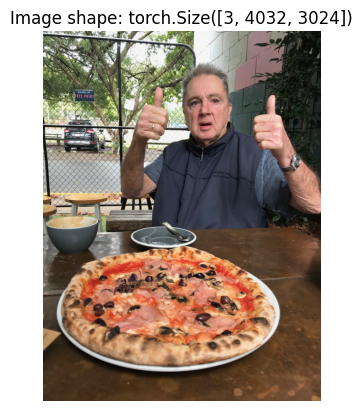

In [37]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

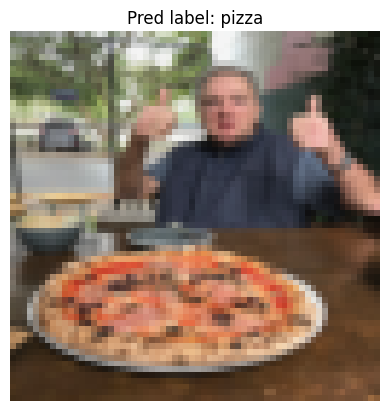

In [41]:
# MAke a prediction on the iamge
model_2.eval()
with torch.inference_mode():

  # Resize image
  resize = transforms.Resize(size=(64,64))
  img = resize(custom_image)

  # Turn image in a single batch and move it to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on the image
  y_pred = model_2(batch)

  # Convert to pred label
  pred_label = torch.argmax(y_pred, dim=1)

# Plot the image and the prediction
plt.imshow(img.permute(1,2,0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);